In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import math

PATH = r"../../Data/completeLoad.csv"
df = pd.read_csv(PATH)
df_h = df.set_index(['zone_id', 'year', 'month', 'day'])

Using TensorFlow backend.


In [2]:
#
unfolded_df = {}
for i, x in enumerate(tqdm(df_h.columns.tolist())):
    col_tuple = df_h[x].to_dict()
    for j, k in col_tuple.items():
        unfolded_df[tuple(list(j) + [i+1])] = k

n_df = pd.DataFrame.from_dict(unfolded_df, orient="index").sort_index()
m_index = pd.MultiIndex.from_tuples(unfolded_df.keys())
#multi index dataframe
#blocks of each day (keeping zone year month day and variating hour) 
mi_df = pd.DataFrame(unfolded_df.values(), m_index).sort_index()

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.27it/s]


In [3]:
# convert pd.DateFrame to np.array of type float and group by zone. mi_df to df_zone
df_zone = np.array([mi_df.loc[(i+1)].values.astype("float32").reshape(
        len(mi_df.loc[(i+1)]),) for i in range(mi_df.index[-1][0])])

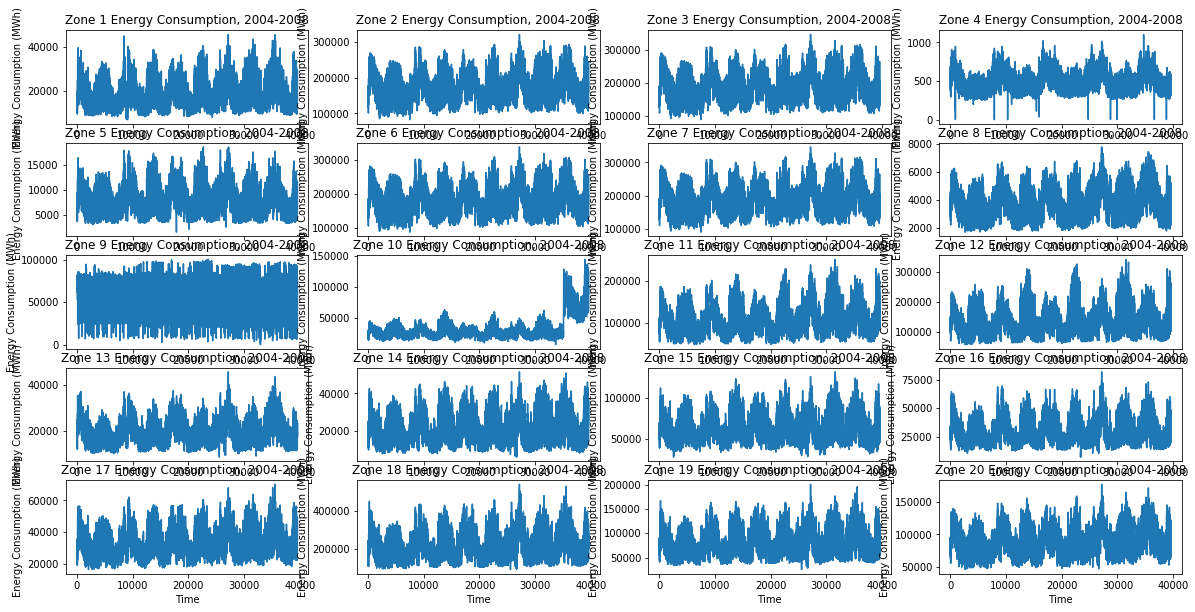

In [4]:
plt.figure(figsize = (20, 10))
for i, x in enumerate(df_zone):
    plt.subplot(5, 4, i+1)
    plt.plot(x)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (MWh)")
    plt.title("Zone {} Energy Consumption, 2004-2008".format(i+1))
plt.show()

In [5]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, Bidirectional
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras import callbacks
import pydot

In [6]:
# use data for zone 1.
data = df_zone[0].reshape(-1, 1)

# normalize data with min max normalization.
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation.
TRAINING_PERC = 0.80

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 31660
Number of samples test set: 7916


In [50]:
# helper function to read data.
def create_dataset_nstep_train(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        ws_2 = int(window_size/2)
        s1 = dataset[i:(i + ws_2), 0]
        s2 = dataset[(i + ws_2 + nstep):(i + window_size + nstep), 0]
        data_x.append(np.concatenate((s1, s2)))
        data_y.append(dataset[(i + ws_2):(i + ws_2 + nstep), 0])
    return(np.array(data_x), np.array(data_y))


def create_dataset_nstep_test(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(0,len(dataset) - window_size - nstep - 1, window_size + nstep):
        ws_2 = int(window_size/2)
        s1 = dataset[i:(i + ws_2), 0]
        s2 = dataset[(i + ws_2 + nstep):(i + window_size + nstep), 0]
        data_x.append(np.concatenate((s1, s2)))
        data_y.append(dataset[(i + ws_2):(i + ws_2 + nstep), 0])
    return(np.array(data_x), np.array(data_y))


def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(200, activation='relu', input_shape = (1, window_size), return_sequences=True)))
    vanilla_rnn.add(Bidirectional(LSTM(200,input_shape = (1, window_size), )))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    
    return(vanilla_rnn)

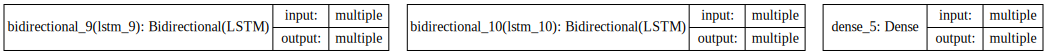

In [51]:
window_size, nstep =  24 * 7 * 4, 24 * 7  
train_X, train_Y = create_dataset_nstep_train(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_test(test, window_size, nstep)

train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))

In [52]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, callbacks=[es])


Train on 26196 samples, validate on 4623 samples
Epoch 1/100
 - 119s - loss: 0.0078 - val_loss: 0.0093
Epoch 2/100
 - 119s - loss: 0.0063 - val_loss: 0.0096
Epoch 3/100
 - 95s - loss: 0.0058 - val_loss: 0.0094
Epoch 4/100
 - 95s - loss: 0.0054 - val_loss: 0.0095
Epoch 5/100
 - 100s - loss: 0.0051 - val_loss: 0.0097
Epoch 6/100
 - 102s - loss: 0.0048 - val_loss: 0.0096
Epoch 7/100
 - 93s - loss: 0.0045 - val_loss: 0.0095
Epoch 8/100
 - 95s - loss: 0.0043 - val_loss: 0.0101
Epoch 9/100
 - 104s - loss: 0.0040 - val_loss: 0.0101
Epoch 10/100
 - 103s - loss: 0.0037 - val_loss: 0.0105
Epoch 11/100
 - 96s - loss: 0.0034 - val_loss: 0.0112
Epoch 00011: early stopping


In [53]:
def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data = normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[:, 0], pred[:, 0]))
    return(score, pred)
#     return pred

mse_train, train_predict = get_predict_and_score(vanilla_rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score(vanilla_rnn, test_X, test_Y)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)

# train_predict = get_predict_and_score(vanilla_rnn, train_X, train_Y)
# test_predict = get_predict_and_score(vanilla_rnn, test_X, test_Y)


Training data error: 1441.92 MSE
Test data error: 1138.85 MSE


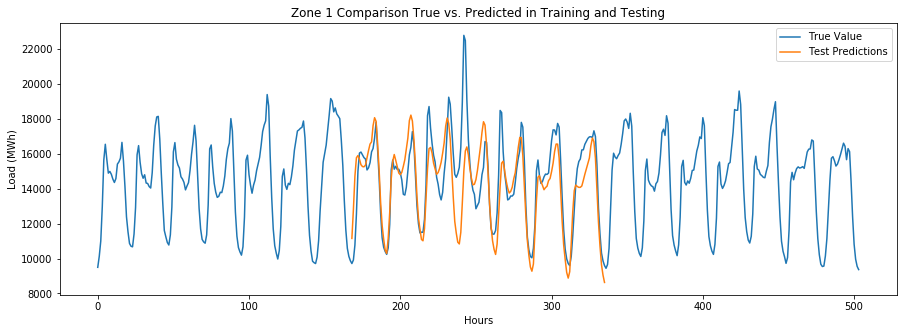

In [70]:
# Training predictions.
# train_predictions = np.empty_like(dataset)
train_predictions = np.zeros(train_predict.shape[0]*train_predict.shape[1]).reshape(train_predict.shape[0],train_predict.shape[1])
train_predictions[0:len(train_predict) + window_size + nstep, :] = train_predict

# Test predictions.
test_predictions = np.empty_like(dataset)
# test_predictions = np.zeros(test_predict[0].shape[0]*test_predict[0].shape[1]).reshape(test_predict[0].shape[0],test_predict[0].shape[1])
test_predictions[:, :] = np.nan

ws_2 = int(window_size/2)
j = 0
auxi = 0
for i in range(train_size,len(dataset) - window_size - nstep - 1, window_size + nstep):
    test_predictions[i + ws_2:i + ws_2 + nstep] = test_predict[j].reshape(nstep, 1)
    j += 1
    if j == 70:
        auxi = i
        break


# # Create the plot.
# plt.figure(figsize = (15, 5))
# plt.plot(normalizer.inverse_transform(dataset)[train_size  + ws_2 - nstep: train_size + ws_2 + 2 * nstep], label = "True Value")
# # plt.plot(train_predictions, label = "Training Predictions")
# plt.plot(test_predictions[train_size + ws_2 - nstep: train_size + ws_2 + 2 * nstep], label = "Test Predictions")
# plt.xlabel("Hours")
# plt.ylabel("Load (MWh)")
# plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
# plt.legend()
# plt.show()
i = 7
n = window_size + nstep
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset)[train_size + i * n + ws_2 - nstep: train_size + i * n + ws_2 + 2 * nstep], label = "True Value")
# plt.plot(train_predictions, label = "Training Predictions")
plt.plot(test_predictions[train_size + i * n + ws_2 - nstep: train_size + i * n + ws_2 + 2 * nstep], label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()

In [23]:
normalizer.inverse_transform(dataset)[train_size + i * n + ws_2 - nstep: train_size + i * n + ws_2 + 2 * nstep]

array([[11921.   ],
       [11816.   ],
       [12456.   ],
       [14201.   ],
       [17119.   ],
       [19518.   ],
       [21293.   ],
       [23207.   ],
       [25739.   ],
       [27660.   ],
       [29110.   ],
       [30020.002],
       [30502.   ],
       [30096.   ],
       [28831.   ],
       [27723.002],
       [26510.   ],
       [23172.   ],
       [19835.   ],
       [17077.998],
       [14817.   ],
       [13619.   ],
       [12809.   ],
       [12195.   ],
       [12231.001],
       [13431.   ],
       [15682.   ],
       [15887.   ],
       [15353.   ],
       [15831.   ],
       [16625.   ],
       [18281.   ],
       [19898.   ],
       [21591.   ],
       [22780.   ],
       [24640.   ],
       [25892.   ],
       [26361.   ],
       [25645.   ],
       [24660.   ],
       [23402.   ],
       [20559.   ],
       [17504.   ],
       [14766.   ],
       [12888.   ],
       [12037.   ],
       [11528.   ],
       [11121.999],
       [11353.001],
       [12612.   ],


In [64]:
test_predictions[train_size + i * n + ws_2 - nstep: train_size + i * n + ws_2 + 2 * nstep].reshape(1, -1)

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,     

In [71]:
(train_size + i * n + ws_2 - nstep, train_size + i * n + ws_2 + 2 * nstep)
import os

In [72]:
test_predictions=test_predictions[train_size + i * n + ws_2 - nstep: train_size + i * n + ws_2 + 2 * nstep].reshape(1, -1)
print(test_predictions)
path = r'../../Data/bidirectionallstm_predictor_168h_window672_37708_38212.csv'
if not os.path.exists(path):
    np.savetxt(path, (test_predictions), delimiter=',')

[[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan   